# Tutorial - Proximal Algorithms
Tutorial on using proximal algorithms for solving optimization problem.

In [1]:
using Pkg
Pkg.add("ProximalOperators");

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [2]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra
using ProximalOperators;

┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/ProximalOperators/ez37h.ji for ProximalOperators [a725b495-10eb-56fe-b38b-717eba820537]
└ @ Base loading.jl:1190


The proximal operator is
$$prox_{\lambda f}(x) = argmin_y \{
f(y) + \frac{1}{2\lambda} ||{y-x}||^2
\}$$

Hence, for each function $f$, the proximal operator will represent something different. For example, let
$f$ is and indicator function $\mathbb 1_C$, where it equals 0 if $x \in C$, else it is $+\infty$. Then,
$prox_f(x)$ is equal to the projection of $x$ in $C$.

#### **Example 1.**
Let $f$ be the L1 norm.

In [3]:
f = NormL1(3.5)

description : weighted L1 norm
domain      : AbstractArray{Real}, AbstractArray{Complex}
expression  : x ↦ λ||x||_1
parameters  : λ = 3.5

In [4]:
x = [1.0, 2.0, 3.0, 4.0, 5.0]
f(x)
y, fy = prox(f, x, 1.0) 

([0.0, 0.0, 0.0, 0.5, 1.5], 7.0)

#### **Example 2.** 
Let $f$ be $\mathbb 1_A$, and $h$ be $\mathbb 1_B$, where A and B are balls.

In [5]:
r1,r2 = 2.0,2.0
f = IndBallL2(r1)
h = IndBallL2(r2)

x = [2.0, 5.0]
b = [2.0, 0.0]
c = [4.8, 0.0]
f = Translate(f, -b)
h = Translate(h, -c)

description : Translation
domain      : AbstractArray{Real}, AbstractArray{Complex}
expression  : x ↦ f(x + b)
parameters  : n/a

Below we plot the proximal point and show that it indeed coincides with the projection.

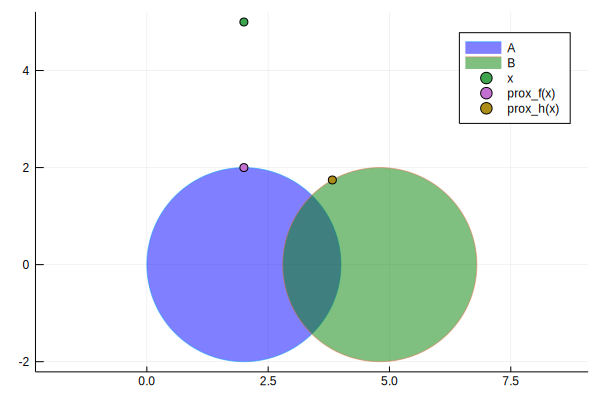

In [6]:
pf, fy = prox(f, x, 1.0)
ph, fy = prox(h, x, 1.0)
xₜ(t) = r1*cos(t)+b[1]
yₜ(t) = r1*sin(t)
zₜ(t) = r2*sin(t)
wₜ(t) = r2*cos(t)+c[1]

plot(xₜ, yₜ, 0, 2π, leg=false, fill=(0,:blue), alpha=0.5,aspect_ratio =1,label="A")
plot!(wₜ, zₜ, 0, 2π, leg=false, fill=(0,:green), alpha=0.5,aspect_ratio =1,label="B")
scatter!([x[1]],[x[2]],label="x")
scatter!([pf[1]],[pf[2]],label="prox_f(x)",legend=true)
scatter!([ph[1]],[ph[2]],label="prox_h(x)",legend=true)

#### **Douglas-Rachford**
Let's now implement the Douglas-Rachford operator (DR).
Let $P_A(x) = prox_f(x) = $projection on A, and
$P_B(x) = prox_h(x) = $projection on B, where $R_A, R_B$ are the reflection operators.
Therefore:
$$DR(x) = \frac{R_f \circ R_h + I}{2}$$
$$R_f(x) =2P_A(x) - I$$

Since DR is a firmly non-expansive operator, we apply DR until it converges to a fixed point, which will be in 
$A \cap B$.

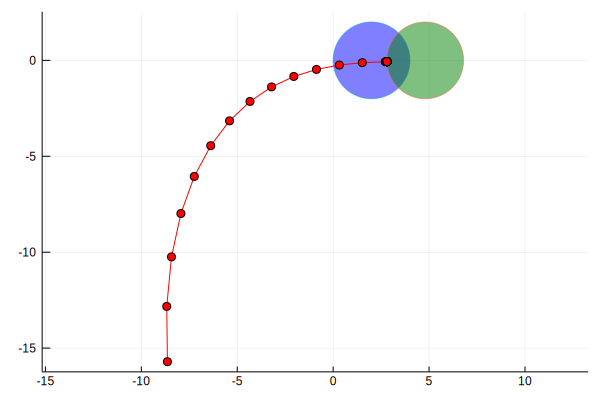

In [531]:
n  = 1000# Number of iterations
# zo = [3.0,10.0] # Initial point of iteration
zo = [randn()*30,randn()*30]
xk = zeros(n,2)
yk = zeros(n,2)
zk = zeros(n,2);
zk[1,:] = zo
for i = 1:n-1
    xk[i,:]  = prox(h, zk[i,:], 1.0)[1]
    yk[i,:]  = prox(f, 2*xk[i,:] - zk[i,:], 1.0)[1]
    zk[i+1,:]= zk[i,:] + yk[i,:] - xk[i,:]
end
plot(xₜ, yₜ, 0, 2π, leg=false, fill=(0,:blue), alpha=0.5,aspect_ratio =1,label="A")
plot!(wₜ, zₜ, 0, 2π, leg=false, fill=(0,:green), alpha=0.5,aspect_ratio =1,label="B")
plot!(zk[:,1],zk[:,2],marker=:circle,c=:red)

#### **Circumcentered-Reflection Method**
Instead of using the DR operator, we iterate through the circumcenter
of $\{x, R_A(x), R_B \circ R_A(x)\}$.

This method was created by [Behling et. al (2017)](https://arxiv.org/abs/1704.06737).

The explicit formula for the general definition of circumcenters used here is from
[Bauschke et. al (2018)](https://arxiv.org/abs/1807.02093).

Let $x_1,...,x_m \in \mathcal H$ be vectors. $S \in \mathcal{P}(\mathcal H) \mid S = \{ x_1, ..., x_m\}$.
$$
CC(S)  = x_1 + \frac{1}{2}(x_2 - x_1,..., x_m - x_1)G(x_2-x_1,...,x_m-x_1)^{-1}
\begin{bmatrix}||x_2-x_1||^2 \\ ... \\ ||x_m -x_1||^2\end{bmatrix}
$$

Where $G$ is the Gram matrix. In this formula, we need that $x_1,...,x_m$ are affinely independent.

In [9]:
# Input a = (a1,a2,...,am), each ai is a vector of space H
# G(a1,...,am) = |<a1,a1> <a1,a2> ... <a1,am> |
#                |<a2,a1> <a2,a2> ... <a2,am> |
#                |...
#                |<am,a1> <am,a2> ... <am,am> |

#### Implementing the generalization of circumcenters

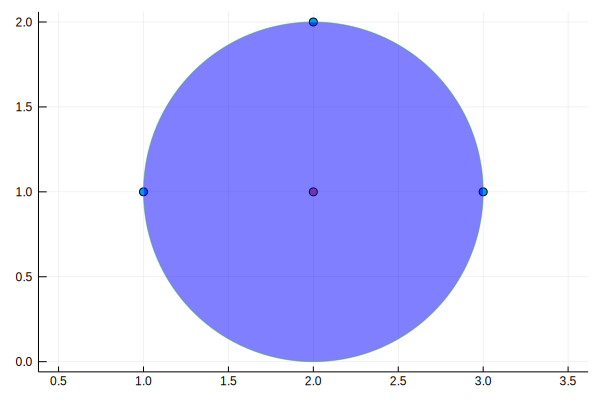

In [10]:
function CC(S)
    T1 = (S.-S[:,1])[:,2:end]
    T2 = pinv(T1' * T1) # MODIFIED THE ORIGINAL BY THE PSEUDO-INVERSE INSTEAD OF THE INVERSE. IT SEEMS TO WORK... WHY?
    T3 = diag((S.-S[:,1])[:,2:end]' * (S.-S[:,1])[:,2:end])
    cc = S[:,1] + 0.5.*T1 * T2 * T3
    return cc
end
S = [1 3 2;
     1 1 2]
circum = CC(S)
rc = norm(circum - S[:,1])
scatter(S'[:,1],S'[:,2])
scatter!([CC(S)[1]],[CC(S)[2]])
ccx(t) = rc*cos(t)+ circum[1]
ccy(t) = rc*sin(t)+ circum[2]

plot!(ccx, ccy, 0, 2π, leg=false, fill=(0,:blue), alpha=0.5,aspect_ratio =1,label="A")

#### The Algorithm
In the initial point zo = [0,10] the algorithm is diverging.

**Why does it diverges?**

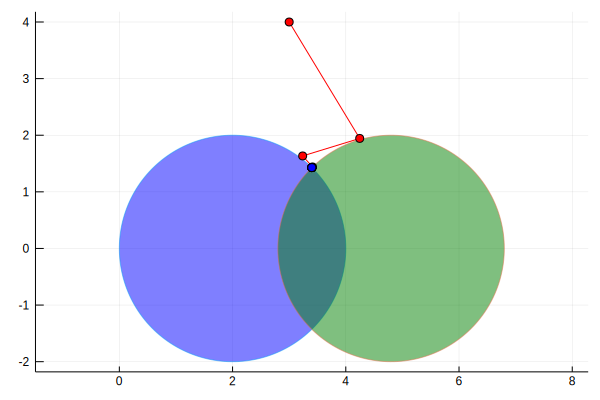

In [147]:
n  = 10# Number of iterations
zk = zeros(n,2);
zo = [3.0,4.0] # Initial point of iteration
# zo = [-13,-3] # Initial point of iteration
zk[1,:] = zo
Ra     = 2*prox(h, zk[1,:], 1.0)[1] - zk[1,:]
Rb_Ra  = 2*prox(f, Ra, 1.0)[1] - Ra
ccz    = CC([zk[1,:] Ra Rb_Ra])
rc = norm(ccz - zk[1,:])

for i = 1:n-1
    Ra     = 2*prox(h, zk[i,:], 1.0)[1] - zk[i,:]
    Rb_Ra  = 2*prox(f, Ra, 1.0)[1] - Ra
    zk[i+1,:]= CC([zk[i,:] Ra Rb_Ra])
end
# plot(xₜ, yₜ, 0, 2π, leg=false, fill=(0,:blue), alpha=0.5,aspect_ratio =1,label="A")
# plot!(wₜ, zₜ, 0, 2π, leg=false, fill=(0,:green), alpha=0.5,aspect_ratio =1,label="B")
# plot!([zk[:,1][1]],[zk[:,2][1]],marker=:circle,c=:red)
# plot!([ccz[1]],[ccz[2]],marker=:circle,c=:black)
plot(xₜ, yₜ, 0, 2π, leg=false, fill=(0,:blue), alpha=0.5,aspect_ratio =1,label="A")
plot!(wₜ, zₜ, 0, 2π, leg=false, fill=(0,:green), alpha=0.5,aspect_ratio =1,label="B")
plot!(zk[:,1],zk[:,2],marker=:circle,c=:red)
plot!([Ra[1]],[Ra[2]],marker=:circle,c=:green)
plot!([Rb_Ra[1]],[Rb_Ra[2]],marker=:circle,c=:blue)

### Methods Variation

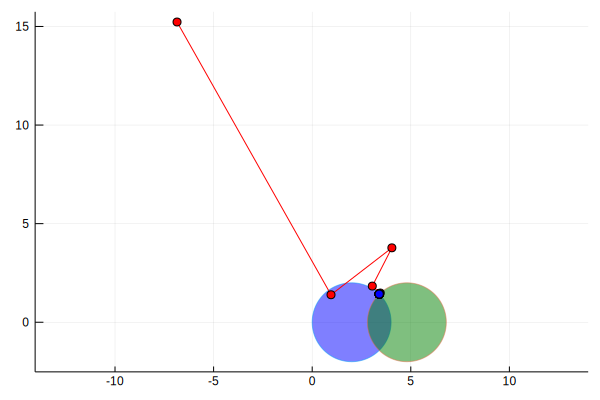

In [553]:
n  = 100# Number of iterations
zk = zeros(n,2);
zo = [0,10.0] # Initial point of iteration
zo = [randn()*30,randn()*30]
zk[1,:] = zo
Ra     = 2*prox(h, zk[1,:], 1.0)[1] - zk[1,:]
Rb_Ra  = 2*prox(f, Ra, 1.0)[1] - Ra
Rb     = 2*prox(f, zk[1,:], 1.0)[1] - zk[1,:]
Ra_Rb  = 2*prox(h, Rb, 1.0)[1] - Rb
# ccz    = CC([zk[1,:] Ra Rb]) ## Parece convergir em todos os casos
ccz    = CC([zk[1,:] Ra Rb Ra_Rb Rb_Ra])
rc = norm(ccz - zk[1,:])

for i = 1:n-1
    Ra     = 2*prox(h, zk[i,:], 1.0)[1] - zk[i,:]
    Rb_Ra  = 2*prox(f, Ra, 1.0)[1] - Ra
    Rb     = 2*prox(f, zk[i,:], 1.0)[1] - zk[i,:]
    Ra_Rb  = 2*prox(h, Rb, 1.0)[1] - Rb
#     zk[i+1,:]= CC([zk[i,:] Ra Rb]) # Parece convergir
#     zk[i+1,:]= CC([zk[i,:] Ra_Rb Rb_Ra])
    zk[i+1,:]= CC([zk[i,:] Ra Rb Ra_Rb Rb_Ra])
end
# plot(xₜ, yₜ, 0, 2π, leg=false, fill=(0,:blue), alpha=0.5,aspect_ratio =1,label="A")
# plot!(wₜ, zₜ, 0, 2π, leg=false, fill=(0,:green), alpha=0.5,aspect_ratio =1,label="B")
# plot!([zk[:,1][1]],[zk[:,2][1]],marker=:circle,c=:red)
# plot!([ccz[1]],[ccz[2]],marker=:circle,c=:black)
plot(xₜ, yₜ, 0, 2π, leg=false, fill=(0,:blue), alpha=0.5,aspect_ratio =1,label="A")
plot!(wₜ, zₜ, 0, 2π, leg=false, fill=(0,:green), alpha=0.5,aspect_ratio =1,label="B")
plot!(zk[:,1],zk[:,2],marker=:circle,c=:red)
plot!([Ra[1]],[Ra[2]],marker=:circle,c=:green)
plot!([Rb_Ra[1]],[Rb_Ra[2]],marker=:circle,c=:blue)

### Symmetric Douglas-Rachford

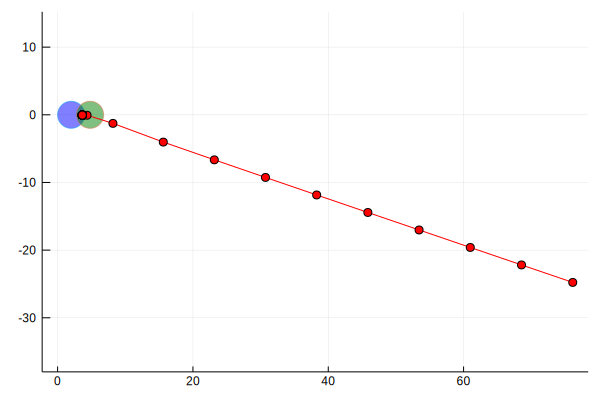

In [540]:
n  = 100# Number of iterations
# zo = [3.0,10.0] # Initial point of iteration
zo = [randn()*30,randn()*30]
xk = zeros(n,2)
yk = zeros(n,2)
xk_ = zeros(n,2)
yk_ = zeros(n,2)
zk = zeros(n,2);
zk[1,:] = zo
for i = 1:n-1
    xk[i,:]  = prox(h, zk[i,:], 1.0)[1]
    yk[i,:]  = prox(f, 2*xk[i,:] - zk[i,:], 1.0)[1]
    xk_[i,:]  = prox(f, zk[i,:], 1.0)[1]
    yk_[i,:]  = prox(h, 2*xk_[i,:] - zk[i,:], 1.0)[1]
    zk[i+1,:]= zk[i,:] + yk[i,:] - xk[i,:] + yk_[i,:] - xk_[i,:]
end
plot(xₜ, yₜ, 0, 2π, leg=false, fill=(0,:blue), alpha=0.5,aspect_ratio =1,label="A")
plot!(wₜ, zₜ, 0, 2π, leg=false, fill=(0,:green), alpha=0.5,aspect_ratio =1,label="B")
plot!(zk[:,1],zk[:,2],marker=:circle,c=:red)

In [226]:
zo
[-8.927333599763644,8.976665594893014]

2-element Array{Float64,1}:
 -8.927333599763644
  8.976665594893014

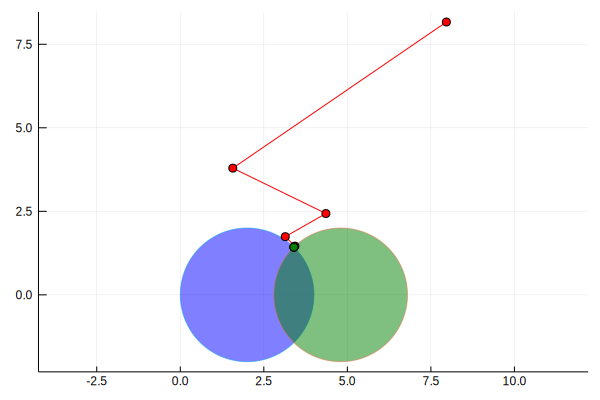

In [473]:
n  = 7# Number of iterations
zk = zeros(n,2);
zk[1,:] = zo
Ra     = 2*prox(h, zk[1,:], 1.0)[1] - zk[1,:]
Rb_Ra  = 2*prox(f, Ra, 1.0)[1] - Ra
Rb     = 2*prox(f, zk[1,:], 1.0)[1] - zk[1,:]
Ra_Rb  = 2*prox(h, Rb, 1.0)[1] - Rb
# ccz    = CC([zk[1,:] Ra Rb]) ## Parece convergir em todos os casos
ccz    = CC([zk[1,:] Ra Rb Ra_Rb Rb_Ra])
rc = norm(ccz - zk[1,:])

for i = 1:n-1
    Ra     = 2*prox(h, zk[i,:], 1.0)[1] - zk[i,:]
    Rb_Ra  = 2*prox(f, Ra, 1.0)[1] - Ra
    Rb     = 2*prox(f, zk[i,:], 1.0)[1] - zk[i,:]
    Ra_Rb  = 2*prox(h, Rb, 1.0)[1] - Rb
#     zk[i+1,:]= CC([zk[i,:] Ra Rb]) # Parece convergir
#     zk[i+1,:]= CC([zk[i,:] Ra_Rb Rb_Ra]) # Parece convergir, mas possui um comportamento estranho
    zk[i+1,:]= CC([zk[i,:] Ra Rb Ra_Rb Rb_Ra]) # 
end
# plot(xₜ, yₜ, 0, 2π, leg=false, fill=(0,:blue), alpha=0.5,aspect_ratio =1,label="A")
# plot!(wₜ, zₜ, 0, 2π, leg=false, fill=(0,:green), alpha=0.5,aspect_ratio =1,label="B")
# plot!([zk[:,1][1]],[zk[:,2][1]],marker=:circle,c=:red)
# plot!([ccz[1]],[ccz[2]],marker=:circle,c=:black)
plot(xₜ, yₜ, 0, 2π, leg=false, fill=(0,:blue), alpha=0.5,aspect_ratio =1,label="A")
plot!(wₜ, zₜ, 0, 2π, leg=false, fill=(0,:green), alpha=0.5,aspect_ratio =1,label="B")
plot!(zk[:,1],zk[:,2],marker=:circle,c=:red)
plot!([Ra[1]],[Ra[2]],marker=:circle,c=:green)
# plot!([Rb_Ra[1]],[Rb_Ra[2]],marker=:circle,c=:blue,xlims=[0,5],ylims=[0,3])

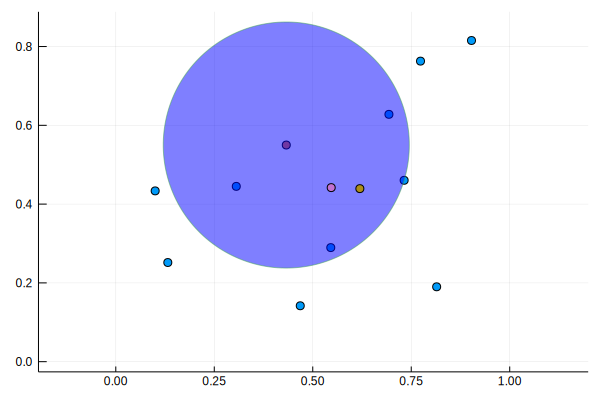

In [88]:
function CC(S)
    T1 = (S.-S[:,1])[:,2:end]
    T2 = pinv(T1' * T1) # MODIFIED THE ORIGINAL BY THE PSEUDO-INVERSE INSTEAD OF THE INVERSE. IT SEEMS TO WORK... WHY?
    T3 = diag((S.-S[:,1])[:,2:end]' * (S.-S[:,1])[:,2:end])
    cc = S[:,1] + 0.5.*T1 * T2 * T3
    return cc
end
S = [1 3 2 2.5;
     1 1 2 0]

S = rand(2,10)
circum = CC(S)
rc = norm(circum - S[:,1])
scatter(S'[:,1],S'[:,2])
scatter!([CC(S)[1]],[CC(S)[2]])
ccx(t) = rc*cos(t)+ circum[1]
ccy(t) = rc*sin(t)+ circum[2]

plot!(ccx, ccy, 0, 2π, leg=false, fill=(0,:blue), alpha=0.5,aspect_ratio =1,label="A")

scatter!([mean(S,dims=2)[1]],[mean(S,dims=2)[2]])
scatter!([median(S,dims=2)[1]],[median(S,dims=2)[2]])

0.42766785008752595